In [1]:
%matplotlib inline
import bluepyopt as bpop
import epileptor_evaluator
import epileptor_util
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt
import pickle
import ukf


def save_obj(obj, name):
    with open('obj/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    with open('obj7470671_success/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    

def plot_sim_trace(sim, x=None, *argv):
    fig = plt.figure(figsize=(10,2))
    if x is None:
        plt.plot(sim.noisy_data[0], *argv)
    else:
        plt.plot(x, sim.noisy_data[0], *argv)
    return fig

/Users/emilyschlafly/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def reload_packages():
    global epileptor_util, epileptor_evaluator, ukf
    epileptor_util = reload(epileptor_util)
    epileptor_evaluator = reload(epileptor_evaluator)
    ukf = reload(ukf)

## Load the parameters from the BluePy optimization

In [20]:
params = {}
params[0] = load_obj('params0')
params[1] = load_obj('params1')
hall_of_fame = load_obj('hall_of_fame')

## Get target
If the target is not saved (i.e. not from data or simulation was not explicitly saved), generate a new one using default parameters. Two files have been saved to be used as targets. One is an EDF file downloaded from ieeg.org; the other is a PKL file containing a simulation using the default parameters from Jirsa.

In [8]:
filename = '/Users/emilyschlafly/BU/Kramer_rotation/' + \
    'ieeg_data/I002_A0003_D010/outputEdf_EDF/outputEdf_0.edf'
# filename = '/Users/emilyschlafly/BU/Kramer_rotation/ieeg_data/target.pkl'

To make a plot that resembles that in the Jirsa paper, use the following:

    target = epileptor_util.epileptor_model(observation_sigmas=25e-4, 
                                        z_init=3.8, noise_ensemble2=15e-2, 
                                        x1_init=0.07, y1_init=0.69, x2_init=-0.7,
                                        g_init=25e-3)
    plt.figure(figsize=(10,2))
    time = np.arange(0,target.total_time,target.dt_sample)
    plt.plot(time, target.noisy_data[0], label='-x1+x2')
    plt.plot(time, target.augmented_state[5,:], label='z')
    plt.legend()
    plt.show()
    
Otherwise, we can run a simulation using the default parameters described in the paper.

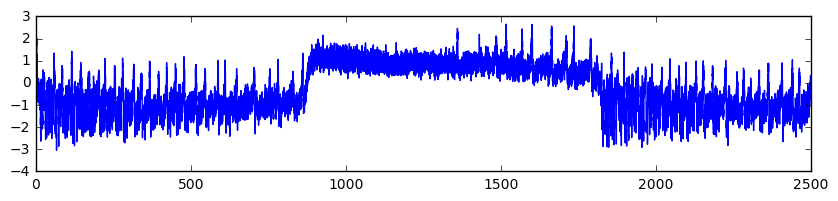

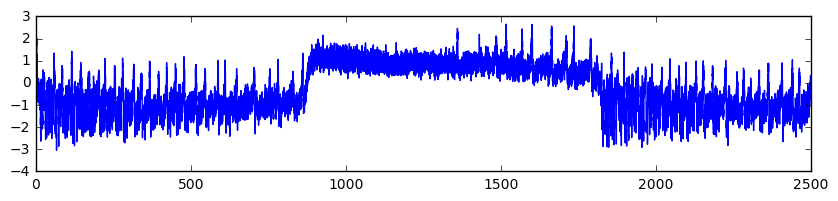

In [3]:
target = epileptor_util.epileptor_model()
target.generate_simulation(plot=False)
plt.figure(figsize=(10,2))
time = np.arange(0,target.total_time,target.dt_sample)
plot_sim_trace(target, x=time)

Create the epileptor model object using the optimized parameters and set the noisy_data attribute of the object to the target data.

In [159]:
np.random.randint(1,100)

78

## State variables for target trace

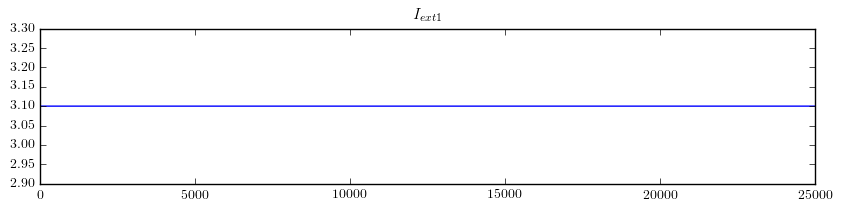

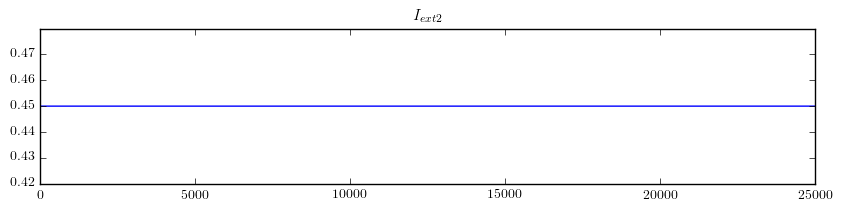

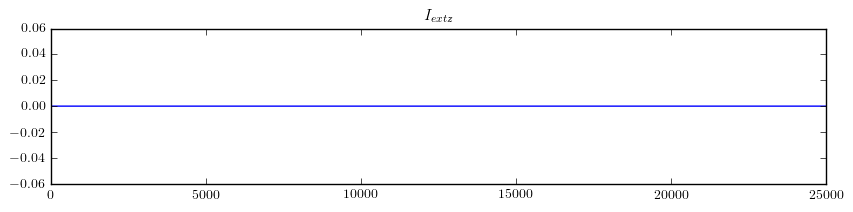

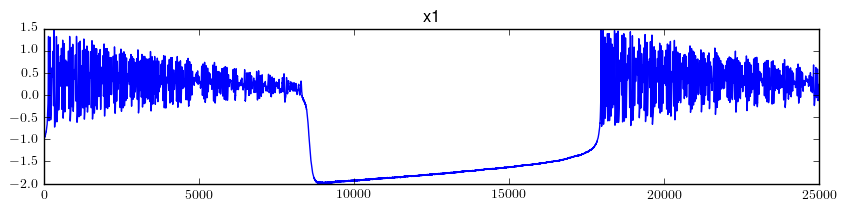

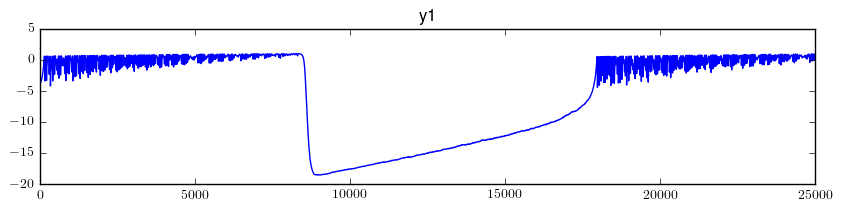

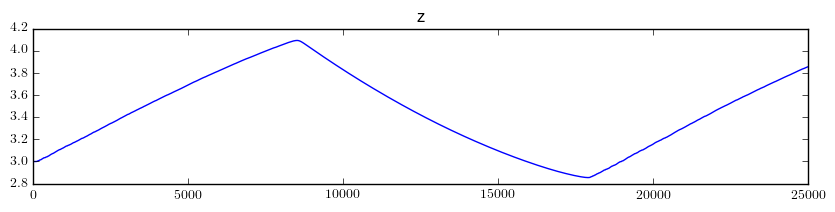

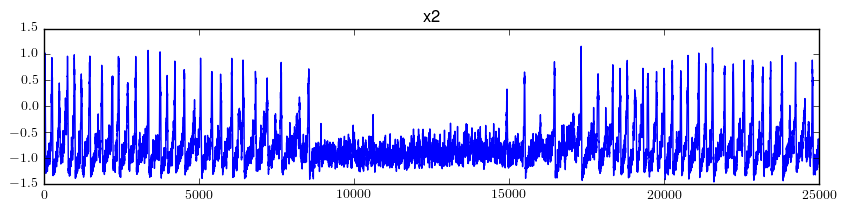

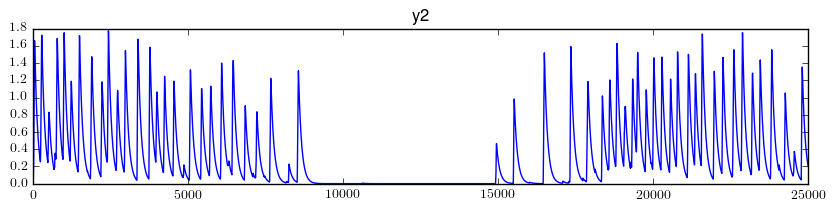

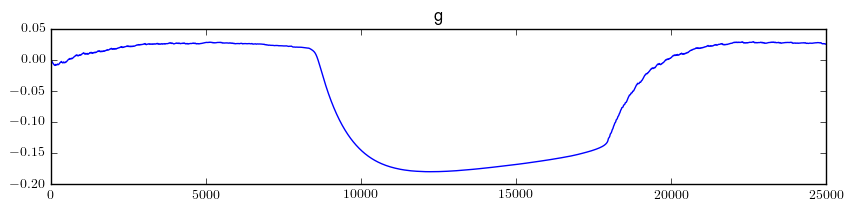

In [101]:
title_strings = np.hstack((target.parameter_names, target.var_names))
for i in range(target.dims_augmented_state):
    plt.figure(figsize=(10,2))
    plt.plot(target.augmented_state[i,:])
    plt.title(title_strings[i])
    plt.show()

In [40]:
for p in evaluator.ep_params:
    print(p[0])

y1_init
z_init
tau0
a
b
c
d
Irest1
Irest2


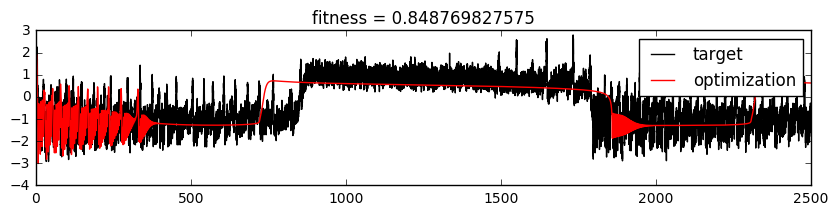

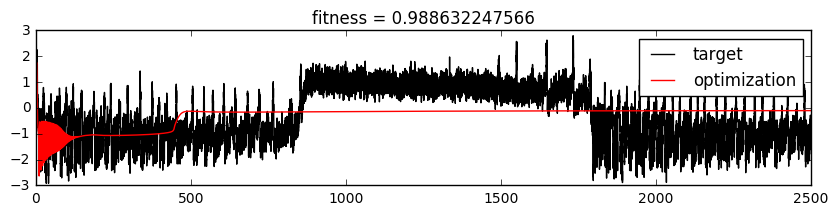

In [34]:
sim = {}
for n in range(2):
    sim[n] = epileptor_util.epileptor_model(params=params[n])
    sim[n].generate_simulation(plot=False)
    fitness = hall_of_fame[n].fitness.values[0]
    plt.figure(figsize=(10,2))
    plt.plot(time, target.noisy_data[0], 'k', label='target')
    plt.plot(time, sim[n].noisy_data[0], 'r', label='optimization')
    plt.title('fitness = ' + str(fitness))
    plt.legend()
    plt.show()

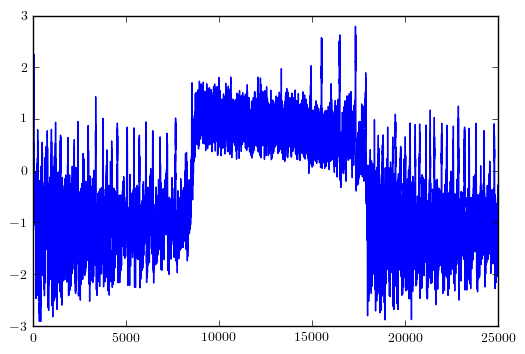

In [92]:
plt.plot(kf[0].noisy_data[0])

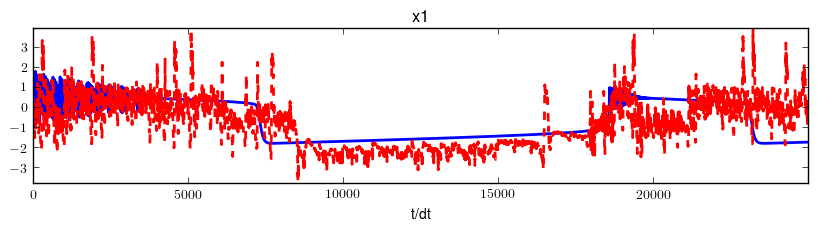

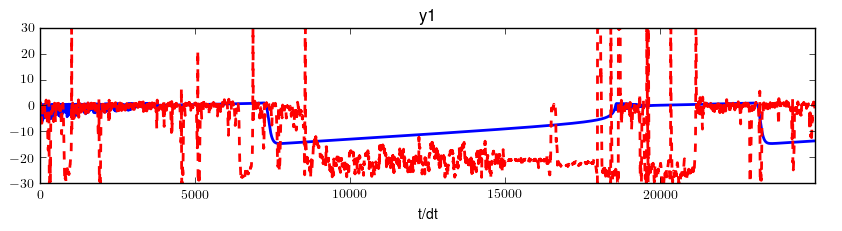

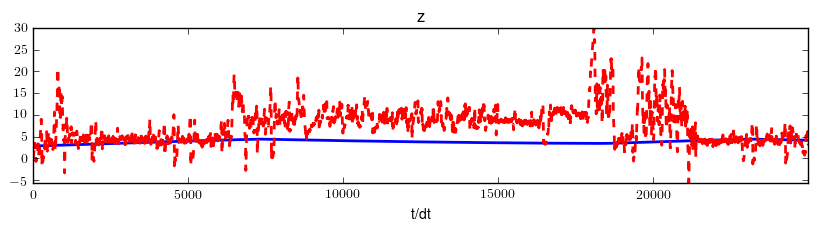

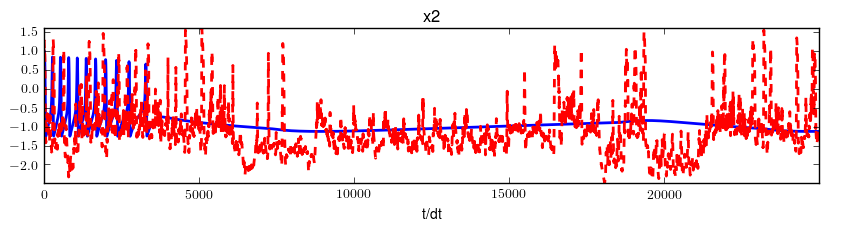

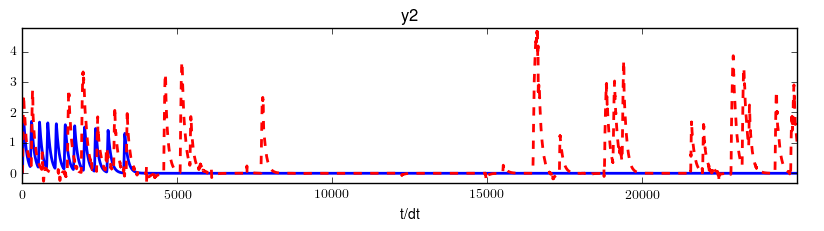

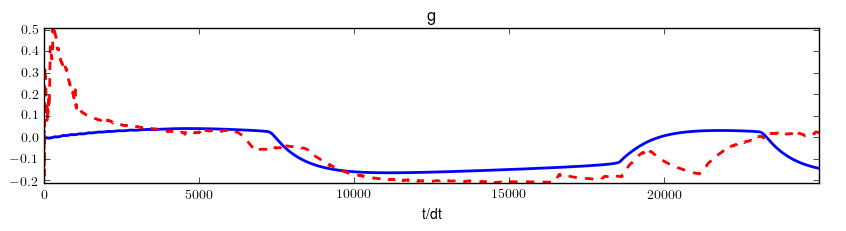

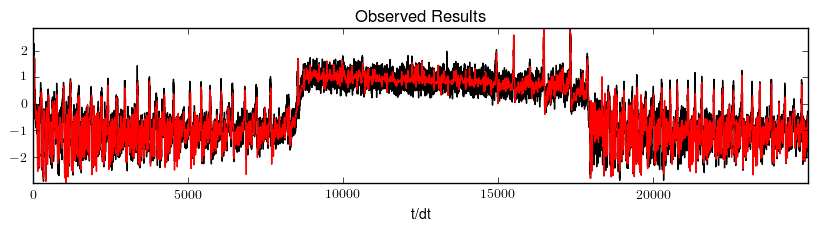

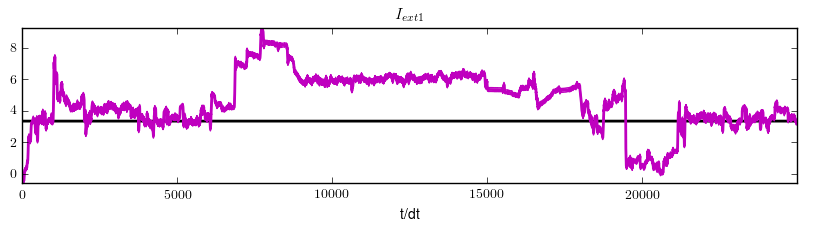

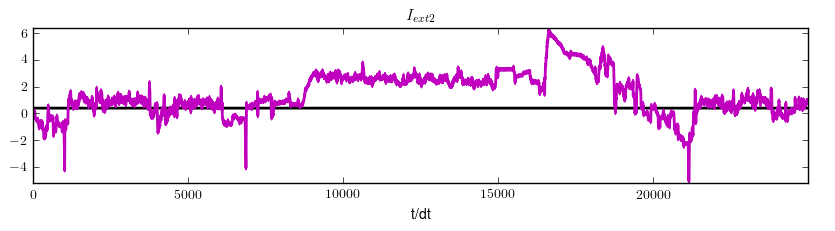

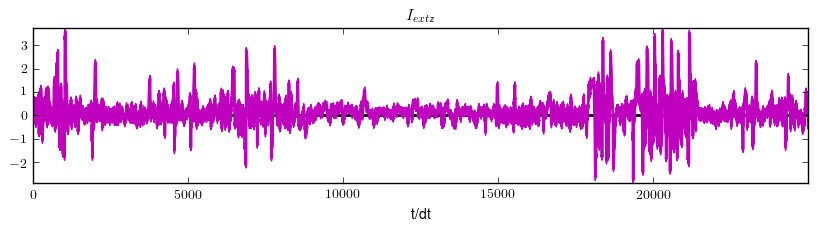

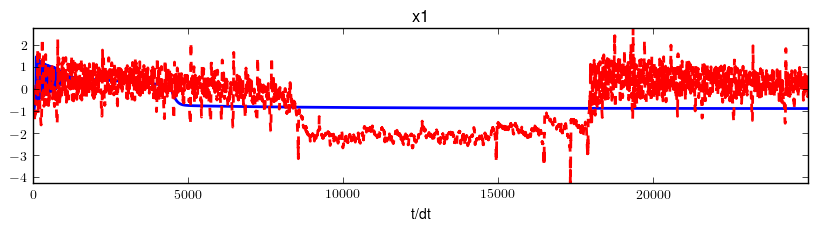

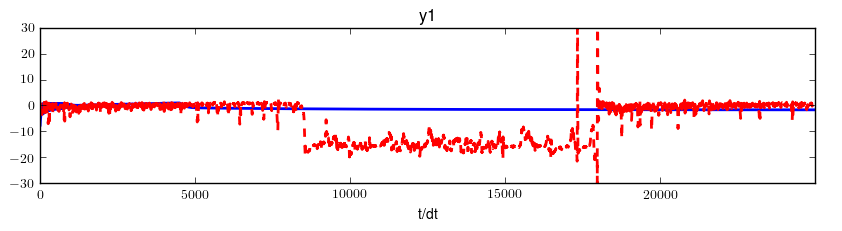

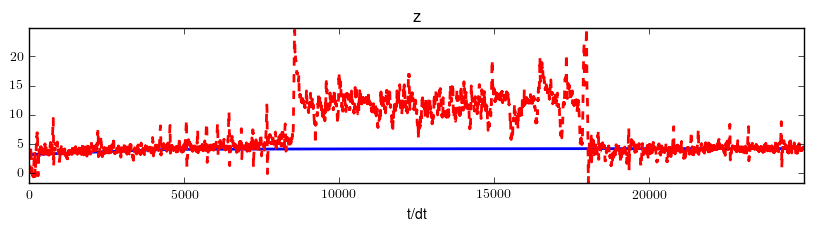

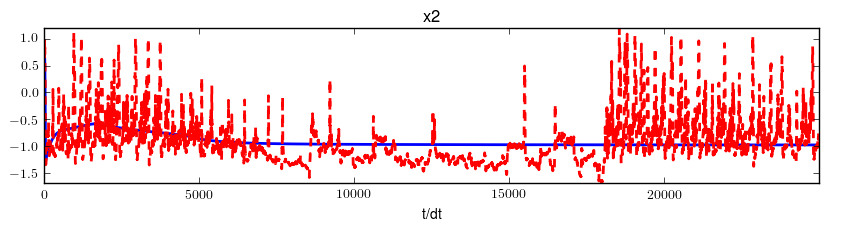

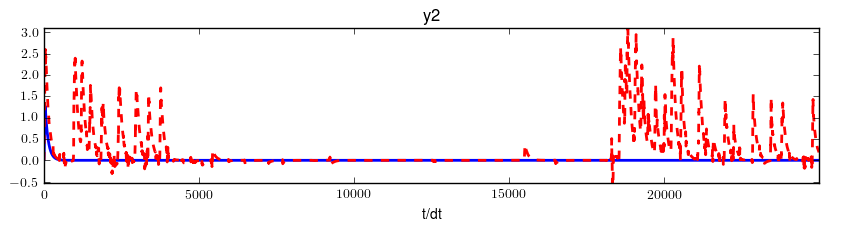

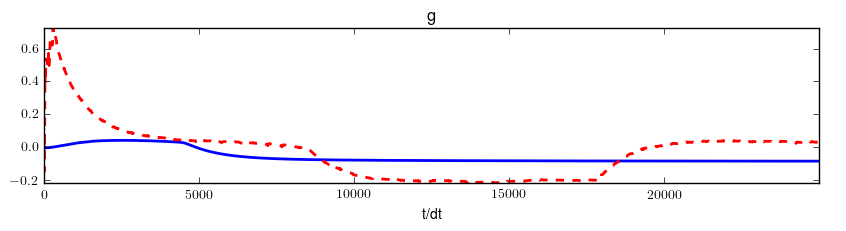

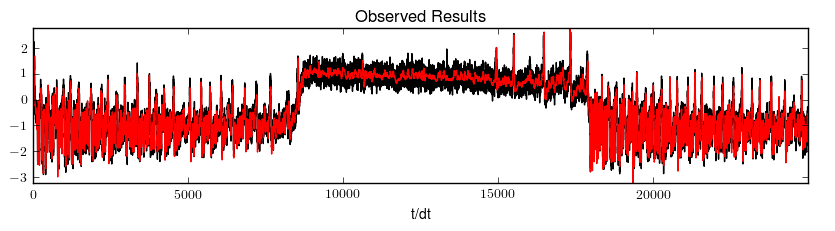

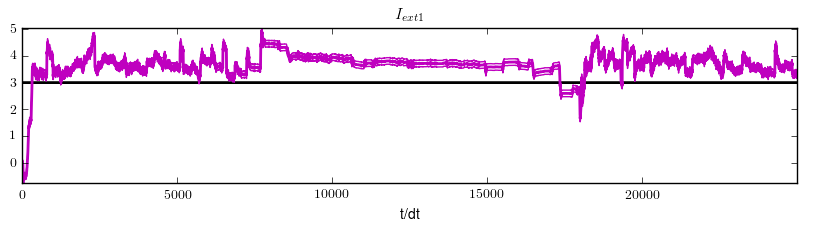

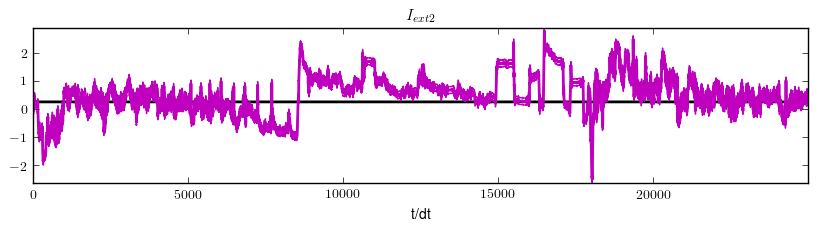

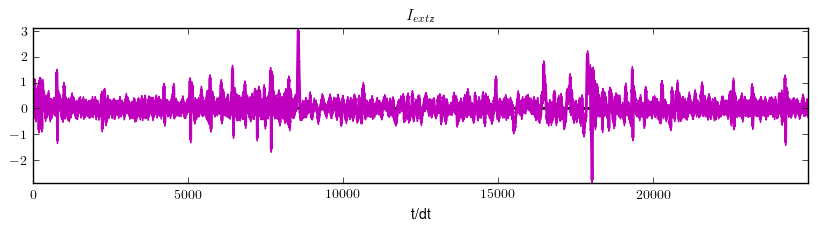

In [93]:
# reload_packages()
kf = {}
for i in range(2):
    sim[i].noisy_data = target.noisy_data
    kf[i] = ukf.unscented_kalman_filter(sim[i])
    kf[i].unscented_kalman(initial_estimate='model')
    kf[i].plot_filter_results(separated=True)

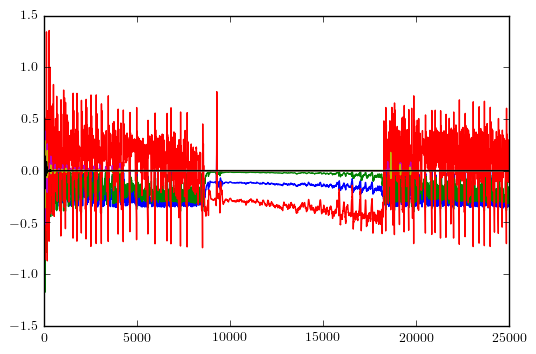

In [107]:
plt.plot(kf.Ks.reshape(7, 25000).T)
plt.show()

## After changing I_ext to reflect current injected into the second ensemble

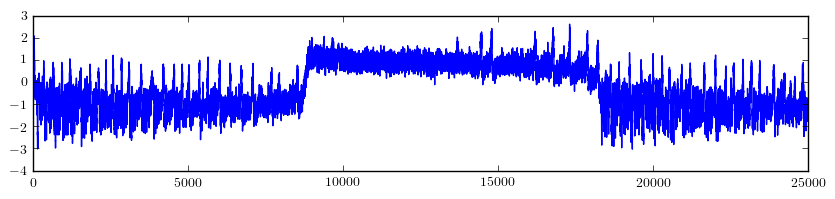

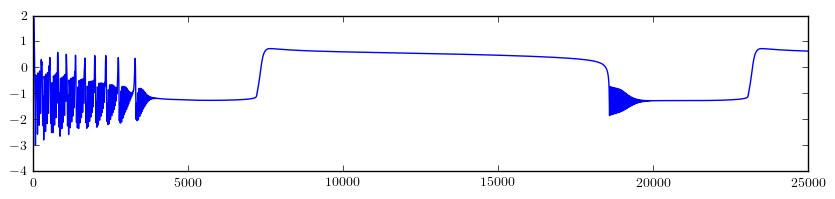

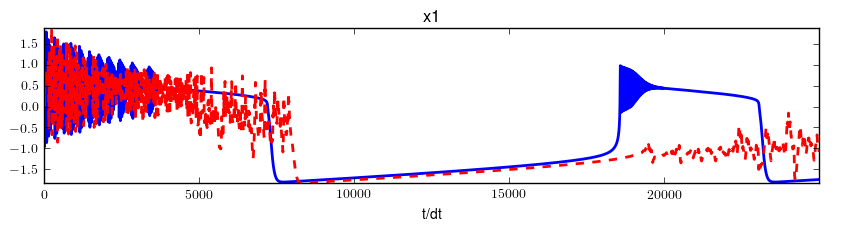

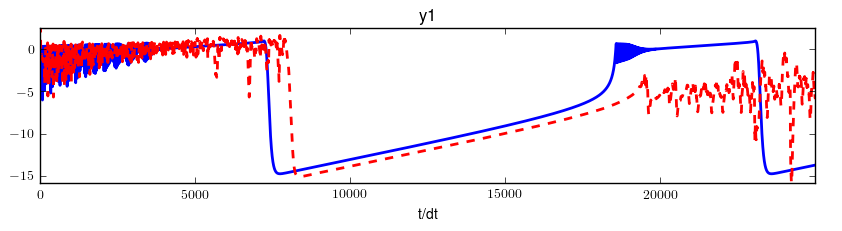

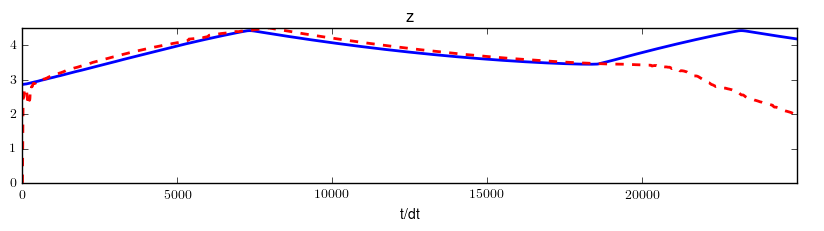

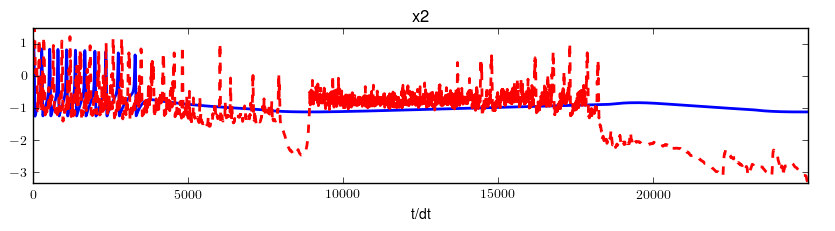

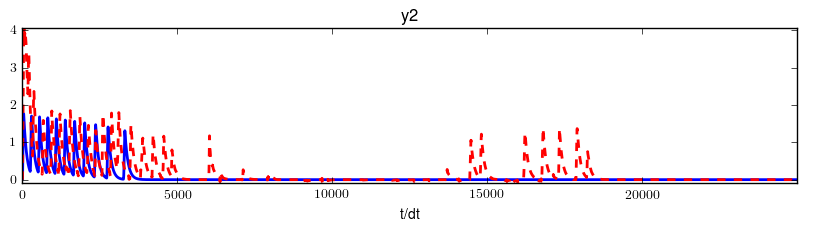

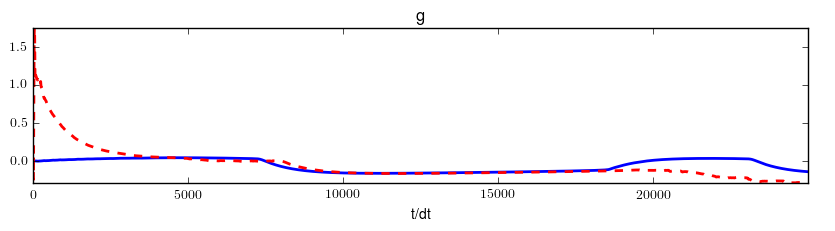

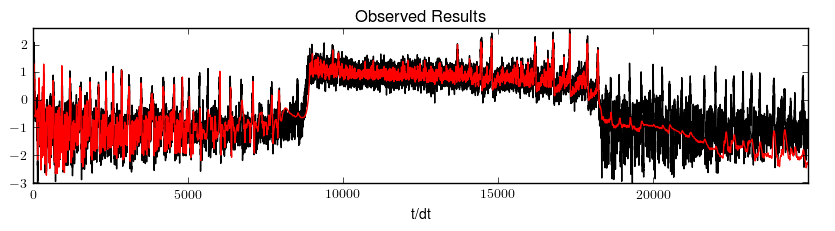

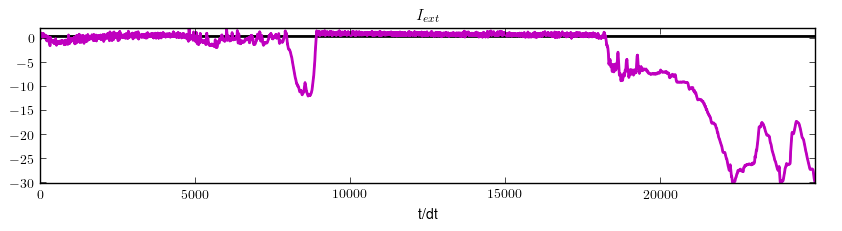

In [108]:
reload_packages()
target = epileptor_util.epileptor_model()
target.generate_simulation(plot=False)
plot_sim_trace(target)
sim = epileptor_util.epileptor_model(params=params0)
sim.generate_simulation(plot=False)
plot_sim_trace(sim)
sim.noisy_data = target.noisy_data
kf = ukf.unscented_kalman_filter(sim)
kf.unscented_kalman(initial_estimate='model')
kf.plot_filter_results(separated=True)

## After adding I_ext parameters for both ensembles and the z variable
By changing the _parameter_sigma_ attribute we can focus on any subset of the parameters. For example

    parameter_sigma=[0, 15e-3, 0]

will run such that only the current injected into the second ensemble is allowed to vary. Note that in the program a sigma of zero is reset to 1e-16 so that the Cholesky decomposition can still be used to generate the sigma points.

Running with all three parameters makes a mess. The following, however, works reasonably well:
    
    parameter_sigma=[15e-3, 15e-4, 0]

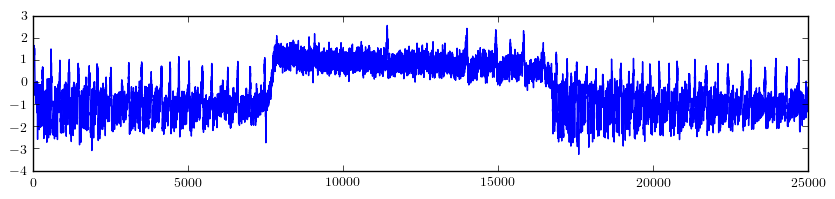

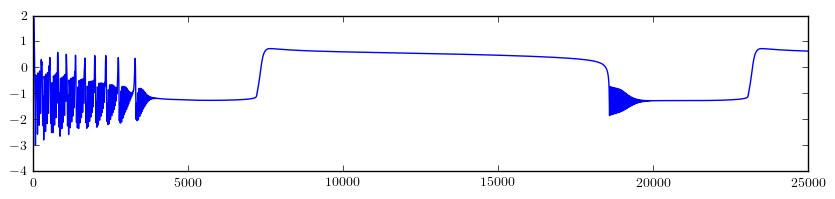

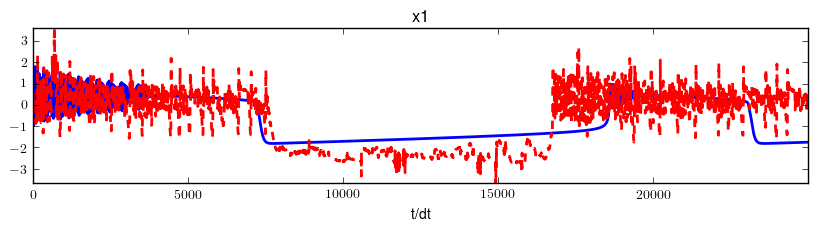

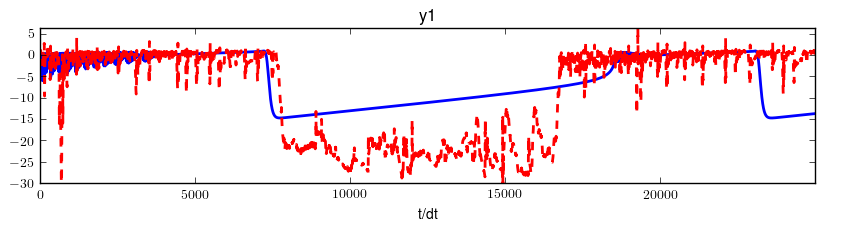

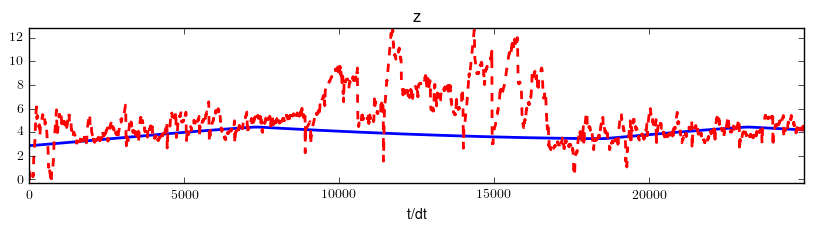

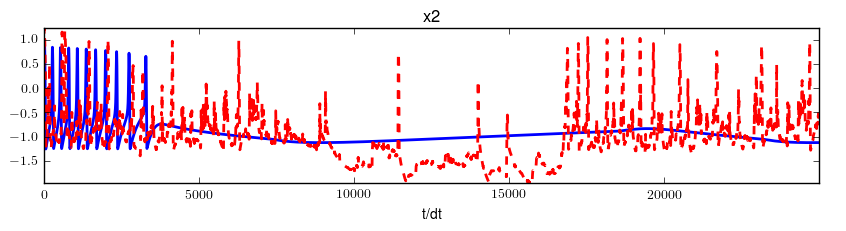

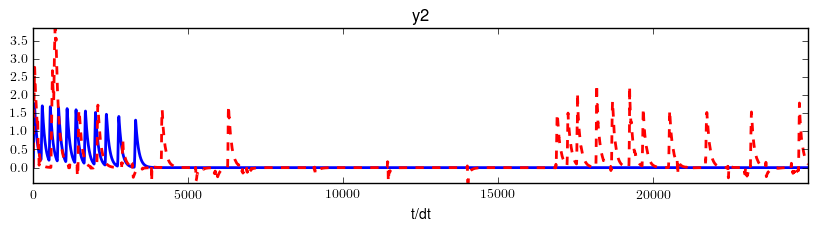

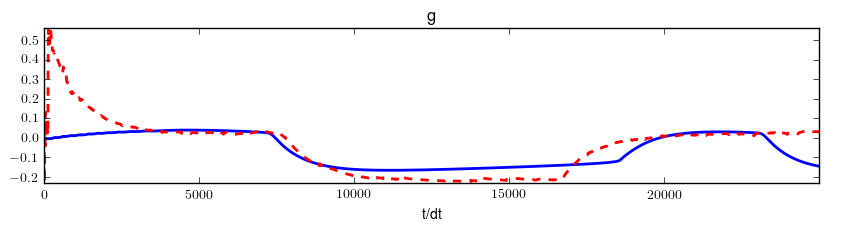

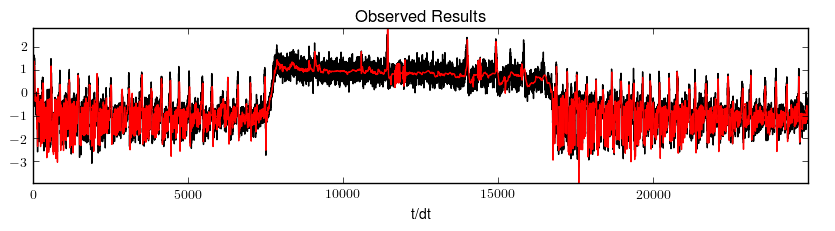

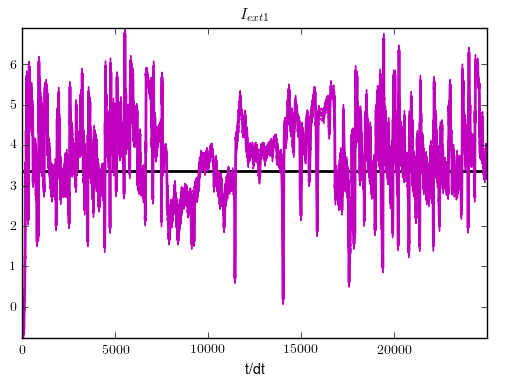

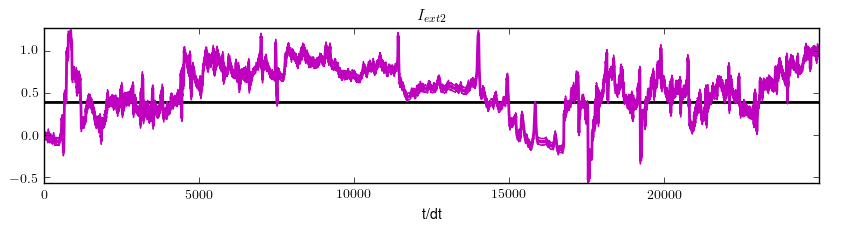

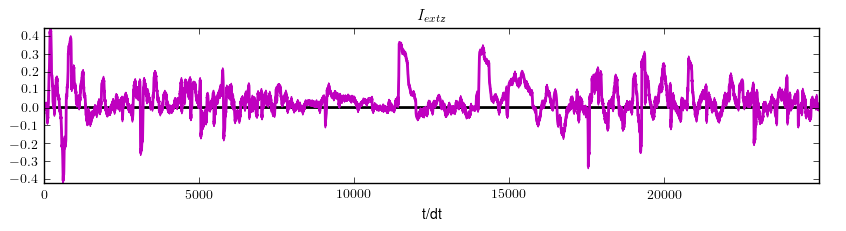

In [158]:
reload_packages()
target = epileptor_util.epileptor_model()
target.generate_simulation(plot=False)
plot_sim_trace(target)
sim = epileptor_util.epileptor_model(params=params0)
sim.generate_simulation(plot=False)
plot_sim_trace(sim)
sim.noisy_data = target.noisy_data
kf = ukf.unscented_kalman_filter(sim, parameter_sigma=[15e-3, 15e-4, 15e-5])
kf.unscented_kalman(initial_estimate='model')
kf.plot_filter_results(separated=True)

## Second pass
In this case, setting the initial estimate of the parameters to the final state of the parameters from a previous run does not make a huge improvement. The parameters were initialized to zero in the first place, though, which is at most 3.1 away from the actual value (in the case of _Irest1_).

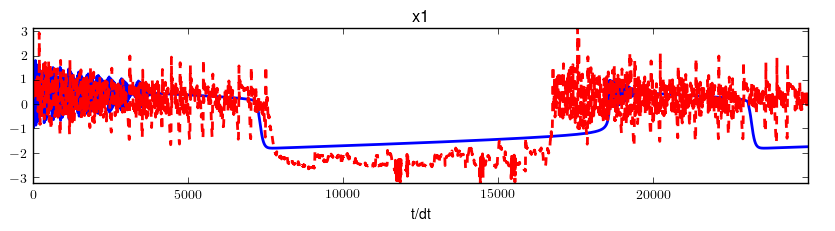

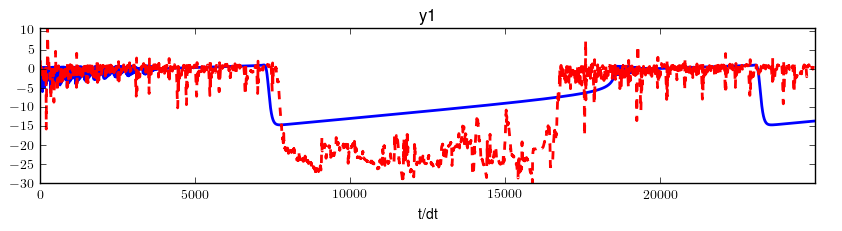

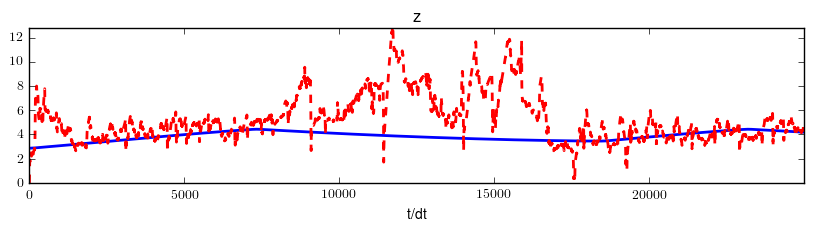

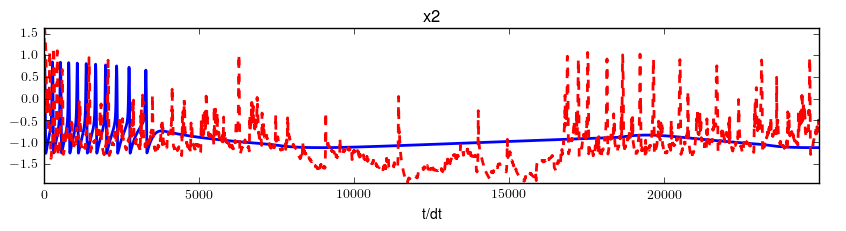

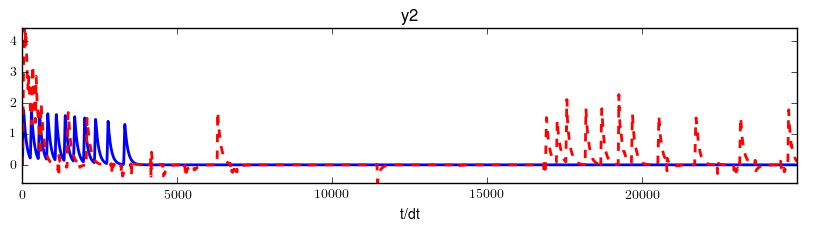

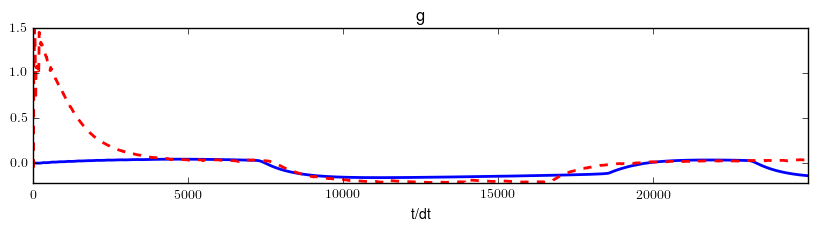

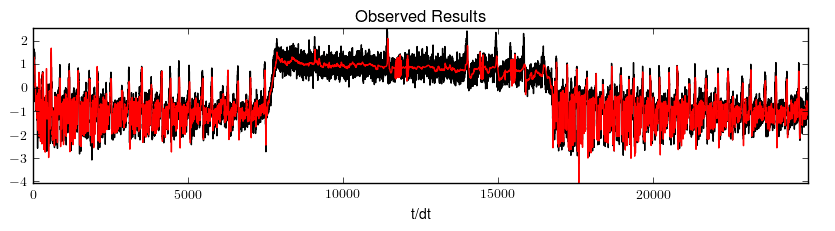

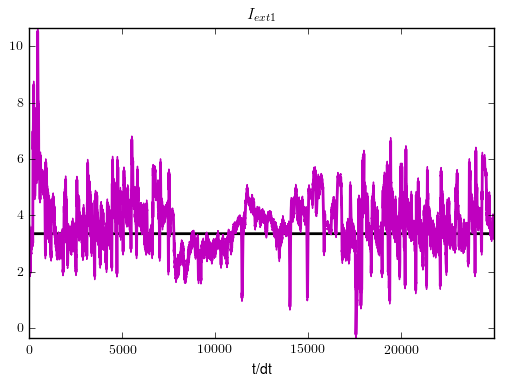

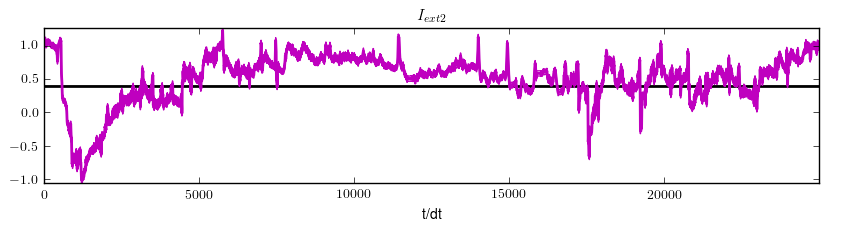

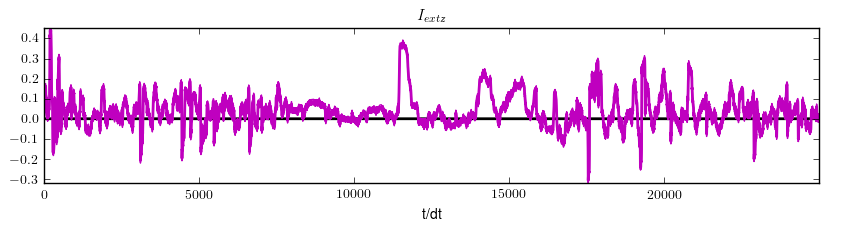

In [159]:
initial_estimate = kf.estimated_state[:, 0]
initial_estimate[:kf.model.dims_params] = kf.estimated_state[:kf.model.dims_params, -1]
kf.unscented_kalman(initial_estimate=initial_estimate)
kf.plot_filter_results(separated=True)